# Analysis of Clinton's mails

In [1]:
import pandas as pd

## Read the file

In [2]:
df = pd.read_csv('Emails.csv')

## Filter the text, search for proper nouns

In [3]:
import re
Word_list =[]
filtered_text_list = []
for row in df.itertuples():
    filtered_text = re.findall('\w+', str(row.ExtractedBodyText), re.UNICODE)
    #tokens = str(text).split()
    filtered_text_list.append(filtered_text)
    capital_list= [word for word in filtered_text if word.istitle()]
    [Word_list.append(Word) for Word in capital_list]
dataframe_f = df[['Id','ExtractedBodyText','MetadataDateSent']].copy()
dataframe_f.loc[:,'filtered_text'] = filtered_text_list

## Analyse the proper nouns

In [4]:
from collections import Counter
Word_dic = Counter(Word_list)

In [5]:
Word_df = pd.DataFrame(list(Word_dic.items()),columns=['word','occur'])
sorted_words = Word_df.sort_values('occur',ascending=False).reset_index(drop=True)

In [6]:
# Find lower case version of nouns
lowc_word_dic = {}
for word in sorted_words.word:
    word_lc = word.lower()
    lowc_word_occur = 0
    for wordlist in dataframe_f.filtered_text:
        if len(set(wordlist)&set([word_lc]))>0:
            word_indices = [i for i, x in enumerate(wordlist) if x == word_lc]
            lowc_word_occur += len(word_indices)
    lowc_word_dic[word] = lowc_word_occur
Wordlc_df = pd.DataFrame(list(lowc_word_dic.items()),columns=['word','lc_occur'])

In [136]:
%%time
lowc_word_dic = {}
for word in sorted_words.word:#[0:100]:
    word_lc = word.lower()
    lowc_word_occur = 0
    for row in dataframe_f.itertuples():
        wordlist = row.filtered_text
        if len(set(wordlist)&set([word_lc]))>0:
            word_indices = [i for i, x in enumerate(wordlist) if x == word_lc]
            lowc_word_occur += len(word_indices)
        if lowc_word_occur>5000:
            break
    lowc_word_dic[word] = lowc_word_occur
Wordlc_df = pd.DataFrame(list(lowc_word_dic.items()),columns=['word','lc_occur'])

CPU times: user 5min 7s, sys: 8 ms, total: 5min 7s
Wall time: 5min 7s


In [139]:
Wordlc_df.sort_values('lc_occur',ascending=False)

,word,lc_occur
6370,S,5077
6077,A,5065
5040,In,5025
8874,To,5017
5240,The,5012
4036,Of,5011
7914,For,5009
4842,And,5008
5825,That,5007
3962,On,5002


### Keep only the proper noun that appear more often in capital than in lower case

In [7]:
df_1 = pd.merge(Word_df, Wordlc_df, on='word', how='outer')
print('Number of words with a capital: {}'.format(len(df_1)))
df_2 = df_1[df_1.occur>df_1.lc_occur].sort_values('occur',ascending=False)
print('Number of words appearing more in capital:: {}'.format(len(df_2)))
df_3 = df_2[df_2.lc_occur<100].sort_values('occur',ascending=False)
print('Number of words appearing less than 100 times without capital: {}'.format(len(df_3)))
df_4 = df_3[df_3.occur>20]
print('Number of words in capital appearing more than 20 times: {}'.format(len(df_4)))

Number of words with a capital: 10074
Number of words appearing more in capital:: 6599
Number of words appearing less than 100 times without capital: 6585
Number of words in capital appearing more than 20 times: 530


## Create the graph

In [41]:
import networkx as nx
import itertools
G = nx.Graph()
for wordlist in dataframe_f.filtered_text:
    wordset = set(wordlist)&set(df_4.word.tolist())
    if len(wordset)>0:
        couples = itertools.combinations(wordset, 2)
            #G.add_edges_from(edge_list)
        for edge in couples:
            if G.has_edge(edge[0],edge[1]):
                # we added this one before, just increase the weight by one
                G[edge[0]][edge[1]]['weight'] += 1
            else:
                # new edge. add with weight=1
                G.add_edge(edge[0], edge[1], weight=1)
        #G.add_edges_from(couples)
        #[G.add_edge(couple) for couple in couples]

### Compute some node and edge properties

In [42]:
# Rescaling edge weights
n1,n2,weights = zip(*G.edges(data='weight'))
edges_id=list(zip(n1,n2))
import numpy as np
print('mean weight: '+str(np.mean(weights))+', max weight: '+str(np.max(weights)))
weights_n=weights/np.max(weights)
weights_n_dic=dict(zip(edges_id,weights_n)) 
nx.set_edge_attributes(G,'weight_norm',weights_n_dic)

mean weight: 3.69035016287, max weight: 239


In [43]:
# Node properties: degree and centrality
degreeDic = G.degree(weight='weight_norm')
nx.set_node_attributes(G,'degree',degreeDic)
#bcDic = nx.betweenness_centrality(G)
#nx.set_node_attributes(G,'bCentrality',bcDic)
degreeDic = G.degree()
nx.set_node_attributes(G,'degree_n',degreeDic)

In [44]:
def normalize_weights(G):
    # Normalize the weights of a graph
    # store the values in the property 'weight_n'
    degreeDic = G.degree(weight='weight')
    nx.set_node_attributes(G,'degree',degreeDic)
    for node1,node2,data in G.edges(data=True):
        degree1 = np.sqrt(G.node[node1]['degree'])
        degree2 = np.sqrt(G.node[node2]['degree'])
        weight = G[node1][node2]['weight']
        G[node1][node2]['weight_n'] = weight/degree1/degree2
    #nx.set_node_attributes(G,'degree',1)
    degreeDic = G.degree(weight='weight')
    nx.set_node_attributes(G,'degree',degreeDic)
    return G

In [45]:
G = normalize_weights(G)

### Community detection

In [54]:
import community
#first compute the best partition
clusterDic = community.best_partition(G)
nx.set_node_attributes(G,'cluster',clusterDic)

<IPython.core.display.Javascript object>


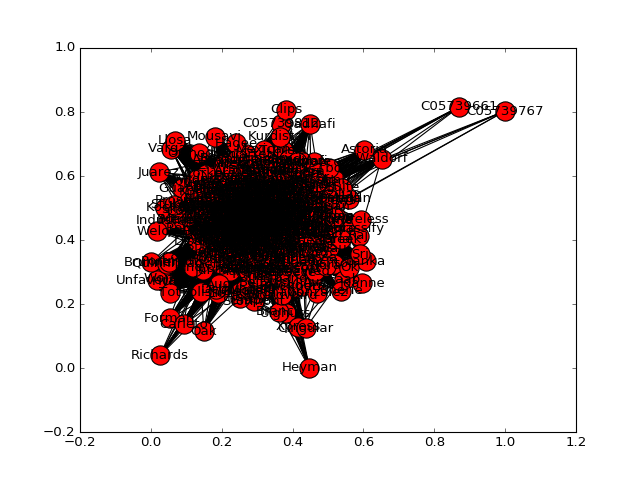

In [318]:
import matplotlib.pyplot as plt
%matplotlib notebook
nx.draw_networkx(G)
plt.show()

In [52]:
# Remove the weakest edges of the most connected nodes
# uses the normailzed weight
print('Initial size: {}'.format(G.size()))
for u,v,a in G.edges(data=True):
    if a['weight_n']<0.009:
        G.remove_edge(u,v)
print('Final size: {}'.format(G.size()))

Initial size: 1997
Final size: 1385


In [372]:
# Remove some edges
print('Initial size: {}'.format(G.size()))
for u,v,a in G.edges(data=True):
    if a['weight']<20:
        G.remove_edge(u,v)
print('Final size: {}'.format(G.size()))

### Write the graph to a file

In [55]:
# Write the graph to a json file
from networkx.readwrite import json_graph
datag = json_graph.node_link_data(G)
import json
s = json.dumps(datag)
datag['links'] = [
        {
            'source': datag['nodes'][link['source']]['id'],
            'target': datag['nodes'][link['target']]['id'],
            'weight': link['weight']
        }
        for link in datag['links']]
s = json.dumps(datag)
with open("viz/HCgraph.json", "w") as f:
    f.write(s)

## Merge nodes with high edge weight (normalized)

In [47]:
def merge_nodes(G,node1,node2,data=False):
    """ merge two nodes node1 and node2 in the graph into one node 
        with id node1+'_'+node2
        if data=None, any data is ignored
        if data='node1' or 'node2' the new node inherit the data of the given node and
        the degree of all nodes is recomputed after merging
    """
    H = G.copy()
    # create the new node
    node_id = node1+'_'+node2
    if data==False:
        H.add_node(node_id)
    elif data==True:
        degree1 = len(G[node1])
        degree2 = len(G[node2])
        if degree1>degree2:
            H.add_node(node_id,H.node[node1])
        else:
            H.add_node(node_id,H.node[node2])
    else:
        raise ValueError("data only accept True or False")
    # connect it to the rest
    for n,n_data in H[node1].items():
        if not (n==node2 or n==node1):
            H.add_edge(node_id,n,weight = n_data['weight'])
    for n,n_data in H[node2].items():
        if not (n==node1 or n==node2):
            H.add_edge(node_id,n,weight = n_data['weight'])
    # remove the initial nodes and edges
    H.remove_node(node1)
    H.remove_node(node2)
    # compute new nodes properties
    # TODO: recompute only for the neighbors of the merged nodes
    H = normalize_weights(H)
    return H

In [48]:
n1,n2,weights = zip(*G.edges(data='weight_n'))
import numpy as np
print('mean weight: '+str(np.mean(weights))+', max weight: '+str(np.max(weights)))

mean weight: 0.00312859414067, max weight: 0.241071428571


In [49]:
# merge the edges with a high normalized weight
for i in range(50):
    source,target,data=max(G.edges(data=True), key=(lambda data: data[2]['weight_n']))
    if data['weight_n']>0.02:
        print(source,target)
        G = merge_nodes(G,source,target,data=True)
    else:
        break

Cingular Xpress
Cingular_Xpress Blackberry
Valmoro Lona
Jiloty Lauren
Abedin Huma
Lanka Sri
Cheryl Mills
Nora Joanne
Assistant Valmoro_Lona
B1 Declassify
Talbott Strobe
En Residence
Waldorf Astoria
Sullivan Jacob
Sullivan_Jacob J
Cherie Blair
Verveer Melanne
Marie Anne
En_Residence Room
Date Doc
H Fw
B6 B5
Thx Ok
Pak Af
B1_Declassify B
Slaughter Marie_Anne
Floor En_Residence_Room
Camera Treaty
Craig Arturo
Thank Nora_Joanne
Date_Doc F
Megan C05739767
Outer Floor_En_Residence_Room
Camera_Treaty Outer_Floor_En_Residence_Room
Feltman Jeffrey
Airport Andrews
Talbott_Strobe Brookings
Camera_Treaty_Outer_Floor_En_Residence_Room Department
Reg Empey
Jiloty_Lauren C
Abedin_Huma Assistant_Valmoro_Lona
Cc Oscar
Fein Sinn
Tel Verveer_Melanne
Robinson Shaun
Ulster Unionist
States United
Cherie_Blair Tony
Mexican Juarez
Cheryl_Mills Sullivan_Jacob_J


In [31]:
for edge in G.edges(data=True):
    if edge[2]['weight_n']>0.25:
        print(edge)